In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from keras.layers import Dense
import pandas as pd

In [3]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Waste_Classification/Dataset_Resized"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [4]:
batch_size = 16
img_height = 150
img_width = 150
data_dir = '/content/drive/MyDrive/Waste_Classification/Dataset_Resized'

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  shuffle=True,
  seed=42,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 3059 files for training.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  shuffle=True,
  seed=42,
  smart_resize=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4369 files belonging to 9 classes.
Using 1310 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 66
Number of test batches: 16


In [8]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)
print(numClasses)

['Aluminium', 'Cardboard', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']
9


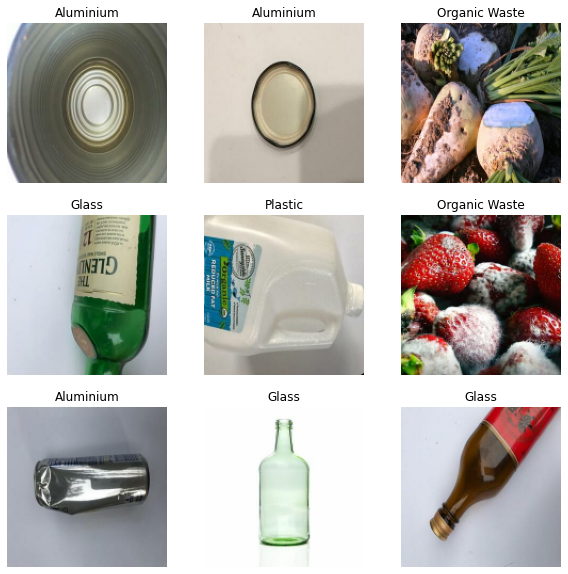

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [10]:
data_augmentation = tf.keras.Sequential(
    [       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
   #tf.keras.layers.RandomZoom(0.2),
    ]
)

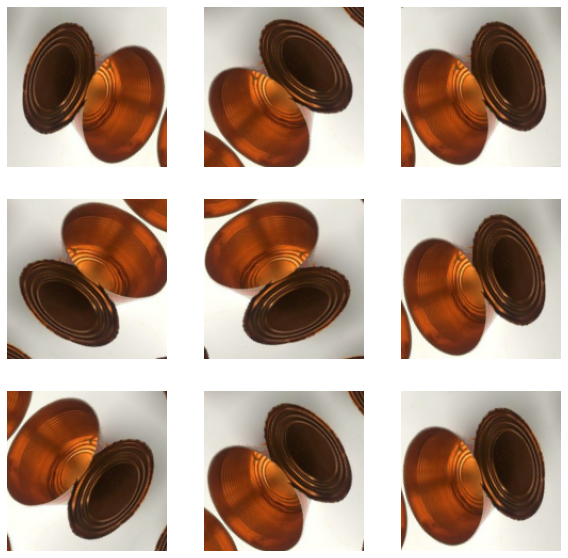

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  
    input_shape=(150, 150, 3),
    include_top=False) 

83697664/83683744 [==============================] - 0s 0us/step


In [14]:
base_model.trainable = False

In [15]:
inputs = tf.keras.Input(shape=(150, 150, 3))

In [16]:
x = data_augmentation(inputs)

In [17]:
x = tf.keras.applications.xception.preprocess_input(x)

In [18]:
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(numClasses, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
192/192 [==============================] - 30s 57ms/step - loss: 1.0406 - accuracy: 0.6401 - val_loss: 0.6545 - val_accuracy: 0.7951
Epoch 2/10
192/192 [==============================] - 8s 41ms/step - loss: 0.6099 - accuracy: 0.8009 - val_loss: 0.5608 - val_accuracy: 0.8197
Epoch 3/10
192/192 [==============================] - 8s 42ms/step - loss: 0.5127 - accuracy: 0.8336 - val_loss: 0.5135 - val_accuracy: 0.8368
Epoch 4/10
192/192 [==============================] - 8s 42ms/step - loss: 0.4777 - accuracy: 0.8401 - val_loss: 0.5097 - val_accuracy: 0.8349
Epoch 5/10
192/192 [==============================] - 8s 42ms/step - loss: 0.4258 - accuracy: 0.8542 - val_loss: 0.4835 - val_accuracy: 0.8435
Epoch 6/10
192/192 [==============================] - 8s 42ms/step - loss: 0.4001 - accuracy: 0.8611 - val_loss: 0.4904 - val_accuracy: 0.8529
Epoch 7/10
192/192 [==============================] - 8s 43ms/step - loss: 0.3967 - accuracy: 0.8669 - val_loss: 0.4591 - val_accuracy: 0.856

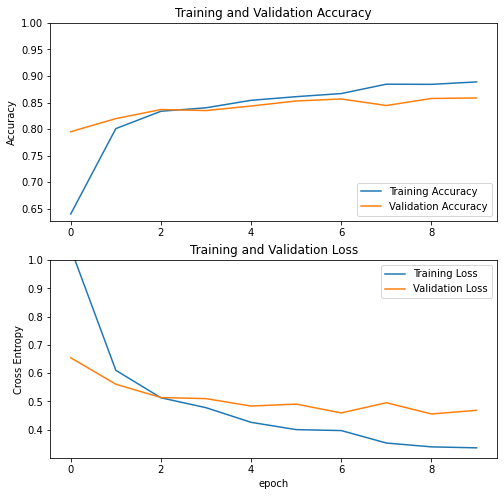

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
base_model.trainable = True

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
! rm -rf logs
%reload_ext tensorboard
log_folder = 'logs'
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5),
             tf.keras.callbacks.ModelCheckpoint(
                 "c5q4.h5", save_best_only=True)]

In [30]:
history_fine = model.fit(train_dataset, epochs=20,validation_data=validation_dataset, callbacks= [callbacks])

Epoch 1/20
192/192 [==============================] - 32s 168ms/step - loss: 0.0388 - accuracy: 0.9879 - val_loss: 0.2828 - val_accuracy: 0.9203
Epoch 2/20
192/192 [==============================] - 32s 167ms/step - loss: 0.0235 - accuracy: 0.9938 - val_loss: 0.4002 - val_accuracy: 0.9042
Epoch 3/20
192/192 [==============================] - 32s 165ms/step - loss: 0.0433 - accuracy: 0.9876 - val_loss: 0.3445 - val_accuracy: 0.8994
Epoch 4/20
192/192 [==============================] - 32s 167ms/step - loss: 0.0776 - accuracy: 0.9771 - val_loss: 0.3317 - val_accuracy: 0.9165
Epoch 5/20
192/192 [==============================] - 32s 166ms/step - loss: 0.0559 - accuracy: 0.9830 - val_loss: 0.3348 - val_accuracy: 0.9213
Epoch 6/20
192/192 [==============================] - 33s 174ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.2764 - val_accuracy: 0.9383
Epoch 7/20
192/192 [==============================] - 32s 166ms/step - loss: 0.0370 - accuracy: 0.9889 - val_loss: 0.3227 - val_ac

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

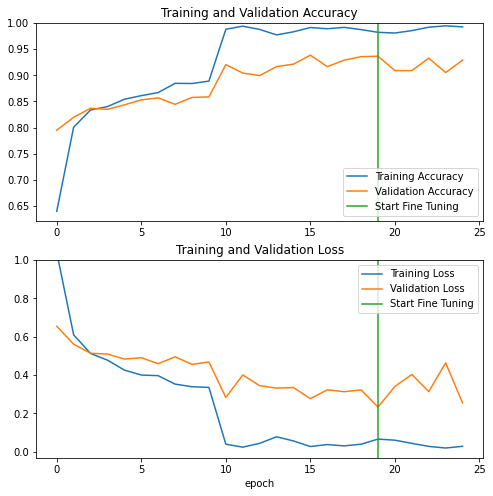

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([20-1,20-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),1])
plt.plot([20-1,20-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
model.save_weights('/content/drive/MyDrive/Waste_Classification')  

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_dataset, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_dataset.take(3))
print("predictions shape:", predictions.shape)

Evaluate on test data
16/16 [==============================] - 1s 43ms/step - loss: 0.1677 - accuracy: 0.9531
test loss, test acc: [0.16766782104969025, 0.953125]
Generate predictions for 3 samples
predictions shape: (48, 9)


[[7.6247773e-08 2.5034632e-07 2.6640205e-07 1.5994409e-07 9.9999881e-01
  3.2753938e-08 2.9448620e-07 2.8373647e-08 7.9565702e-08]]
Prediction: Other Plastics


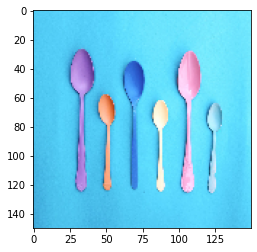

In [36]:
path = "/content/Spoon.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions)
print("Prediction: " + str(classes[np.argmax(predictions)]))